In [1]:
import scipy.io 
import numpy as np 
import pandas as pd
import scipy.sparse
import os
import json
import random
import time
import yaml
from matplotlib import pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 14, 8
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay

import utils
import multi_layer_perceptron as mlp
import perceptron

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


SEED = 8 # after some testing this seed seems to work very well
random.seed(SEED)

## Data

### load the data and bring it into the desired format

In [7]:
data = scipy.io.loadmat('emails.mat') #load matlab data using the loadmat function
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Dec 07 13:57:47 2010',
 '__version__': '1.0',
 '__globals__': [],
 'X': <57173x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2351499 stored elements in Compressed Sparse Column format>,
 'Y': array([[ 1, -1,  1, ...,  1,  1,  1]], dtype=int16)}

The X data is given as a 57173x10000 dense matrix. For this project I want it to be row by row instead of column by column and to transpose the matrix it has to be decompressed. Decompression can be done by using the Objects method todense() which returns a standard numpy array. This array can then be transposed into the wanted format.\
The Y data is not compressed and can be read directly. It is however also stored as a column vector (1x10000) and for this project I want it as a row vector (10000) which can be archieved by reshaping it into just one dimension (-1 means the size of the dimension should be infered).

In [8]:
X = np.asarray(data['X'].astype('int16').todense().transpose(1,0)) # since this data is in a compressed sparse representation it is decompressed using the todense() method
Y = np.asarray(data['Y'].reshape(-1)) # the labels are not compressed and can be read directly

In [9]:
# add a one to all instances for the offset
X = np.hstack([X,np.ones([X.shape[0], 1], dtype='int16')])

In [10]:
print(X.shape)
print(Y.shape)

(10000, 57174)
(10000,)


### split data into train/test sets

I chose a train/test split of 80/20 and did not create a validation split since there are no hyperparameters to be tuned with this model.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state = SEED)

## Perceptron from scratch

Implementation of the Perceptron Model and algorithm in NumPy. For documentation look at perceptron.py

A pretrained version of this model is stored in models/perceptron_weights.npy. To look at the results, skip to the 'pre-trained' subsection after initiallizing the model.

In [12]:
config = {'weigth_size': X_train.shape[1]}
model = perceptron.Perceptron(config) # initiallization

### training

In [13]:
perceptron.train_perceptron(model, (X_train, Y_train), (X_test, Y_test), 50)

0 :  epoch loss =  1191796.0 	 Accuracy =  0.955625
5 :  epoch loss =  117515.0 	 Accuracy =  0.992375
10 :  epoch loss =  894.0 	 Accuracy =  0.99925
15 :  epoch loss =  426.0 	 Accuracy =  0.999625
20 :  epoch loss =  264.0 	 Accuracy =  0.99975
25 :  epoch loss =  334.0 	 Accuracy =  0.99925
30 :  epoch loss =  89.0 	 Accuracy =  0.999875
35 :  epoch loss =  31.0 	 Accuracy =  0.999875
stopping in epoch 39 due to no changes

Test Data:
=== Prediction Analysis ===
data points:       2000
-----------------------------
true positives:    1594 (0.79700)
false positives:   4 (0.00200)
true negatives:    389 (0.19450)
false negatives:   13 (0.00650)
-----------------------------
accuracy:          0.99150
precision:         0.99750
recall (tpr):      0.99191
fpr:               0.01018

All the Data:
=== Prediction Analysis ===
data points:       10000
-----------------------------
true positives:    8017 (0.80170)
false positives:   4 (0.00040)
true negatives:    1966 (0.19660)
false nega

### saving

In [14]:
# with open(os.path.join('models', 'perceptron_weigths.npy'), 'wb') as f:
#     np.save(f, model.weights)

### pre-trained

In [15]:
with open(os.path.join('models', 'perceptron_weigths.npy'), 'rb') as f:
    model.weights = np.load(f)
perceptron.test_perceptron(model, (X_train, Y_train), (X_test, Y_test))


Test Data:
=== Prediction Analysis ===
data points:       2000
-----------------------------
true positives:    1594 (0.79700)
false positives:   4 (0.00200)
true negatives:    389 (0.19450)
false negatives:   13 (0.00650)
-----------------------------
accuracy:          0.99150
precision:         0.99750
recall (tpr):      0.99191
fpr:               0.01018

All the Data:
=== Prediction Analysis ===
data points:       10000
-----------------------------
true positives:    8017 (0.80170)
false positives:   4 (0.00040)
true negatives:    1966 (0.19660)
false negatives:   13 (0.00130)
-----------------------------
accuracy:          0.99830
precision:         0.99950
recall (tpr):      0.99838
fpr:               0.00203


### precision-recall curve

In [16]:
preds = np.empty(Y.shape[0])
for i in range(len(Y)):
    preds[i] = model.forward(X[i])
preds = np.sign(preds)

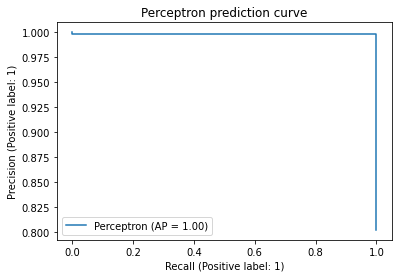

In [17]:
display = PrecisionRecallDisplay.from_predictions(
    preds, Y, name="Perceptron"
)
_ = display.ax_.set_title("Perceptron prediction curve")

## Multi-layer Perceptron as a more complex approach

The model can be trained in this notebook though I recommend running it directly from command line ($ python multi_layer_perceptron.py) especially when running this on a GPU since Jupyter notebooks will store values in your GPU's RAM even after the computation.

A pre-trained model is again provided. To run it you can skip to the 'pre-trained' subsection after initiallization.

Additional documentation is provided in multi_layer_perceptron.py

### initialization

In [19]:
# loading experiment configurations
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

torch.manual_seed(config['manual_seed']) # set a manual seed for reproducability
torch.cuda.manual_seed(config['manual_seed']) # also need to set it for runs on GPU

# setting up the data in dataloaders
data = scipy.io.loadmat('emails.mat')
X_torch = np.asarray(data['X'].astype('float32').todense().transpose(1,0)) 
Y = np.asarray(data['Y'].astype('float32').reshape(-1)) 
Y_torch = (Y+1)/2 # labels are given as [-1, 1] but need to be [0,1] for binary Cross Entropy Loss
config['in_size'] = X_torch.shape[1]
X_train, X_test, Y_train, Y_test = train_test_split(X_torch, Y_torch, train_size = config['train_size'], shuffle=True, random_state=config['manual_seed'])
trainset = utils.Dataset(X_train, Y_train)
train_loader = DataLoader(trainset, batch_size=config['batch_size'])
testset = utils.Dataset(X_test, Y_test)
test_loader = DataLoader(testset, batch_size=config['batch_size'])

# initiallizing the model
model = mlp.MLP(config) # initiallizes MLP model
model = model.to(device) # only effects GPU environments

### training

In [20]:
# training the model
model.train()
optimizer = optim.Adam(params = model.parameters(), lr=config['lr']) # Adam seems to be a good multi-purpose Optimizer
loss_fn = nn.BCELoss() # binary Cross Entropy Loss
losses, train_accs, test_accs = mlp.train(model, optimizer, loss_fn, train_loader, config, test_loader) # trains the model and returns results

# logging the training results
log_data = {'losses': losses, 'train_accs': train_accs, 'test_accs': test_accs}
with open(os.path.join('results', f'{config["manual_seed"]}.json'), 'w') as f:
    json.dump(log_data, f) # log training results
print()

# running tests and printing results
model.eval()
utils.run_analysis(model, train_loader, test_loader, device)

Epoch 0:    Loss = 0.6853628270328045
                   Train Accuracy =  0.79725
                   Test Accuracy =  0.8055000000000001
Epoch 20:    Loss = 0.04138851631432772
                   Train Accuracy =  0.999
                   Test Accuracy =  0.9995
Epoch 40:    Loss = 0.012462797050829977
                   Train Accuracy =  0.999625
                   Test Accuracy =  0.9995

----- Only Test Set -----
=== Prediction Analysis ===
data points:       2000
-----------------------------
true positives:    1623 (0.81150)
false positives:   0 (0.00000)
true negatives:    376 (0.18800)
false negatives:   1 (0.00050)
-----------------------------
accuracy:          0.99950
precision:         1.00000
recall (tpr):      0.99938
fpr:               0.00000
----- All the Data -----
=== Prediction Analysis ===
data points:       10000
-----------------------------
true positives:    8028 (0.80280)
false positives:   2 (0.00020)
true negatives:    1968 (0.19680)
false negatives:   2 (0

In [21]:
### saving ###
# torch.save(model.state_dict(), os.path.join('models', 'mlp.pth'))

### pre-trained

In [22]:
model.load_state_dict(torch.load(os.path.join('models', 'mlp.pth')))
model.eval()
utils.run_analysis(model, train_loader, test_loader, device)

----- Only Test Set -----
=== Prediction Analysis ===
data points:       2000
-----------------------------
true positives:    1623 (0.81150)
false positives:   0 (0.00000)
true negatives:    376 (0.18800)
false negatives:   1 (0.00050)
-----------------------------
accuracy:          0.99950
precision:         1.00000
recall (tpr):      0.99938
fpr:               0.00000
----- All the Data -----
=== Prediction Analysis ===
data points:       10000
-----------------------------
true positives:    8027 (0.80270)
false positives:   3 (0.00030)
true negatives:    1967 (0.19670)
false negatives:   3 (0.00030)
-----------------------------
accuracy:          0.99940
precision:         0.99963
recall (tpr):      0.99963
fpr:               0.00152


### precision-recall curve

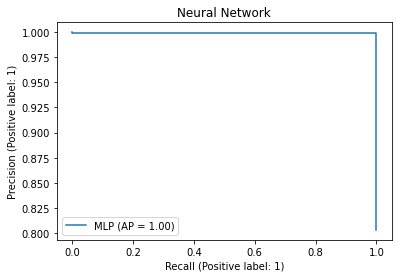

In [30]:
preds = model(torch.tensor(X_torch, device=device))
preds = preds.cpu().detach().numpy()
preds = np.sign(preds-0.5)
display = PrecisionRecallDisplay.from_predictions(
    preds, Y, name="MLP"
)
_ = display.ax_.set_title("Neural Network")

## Data visualizations

### Perceptron

In [24]:
with open(os.path.join('results', 'perc3.json'), 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,losses,train_accs,test_accs
0,1293204.0,0.949429,0.972333
1,358742.0,0.983286,0.978000
2,125203.0,0.990714,0.991333
3,50671.0,0.995571,0.992000
4,8692.0,0.998000,0.992667


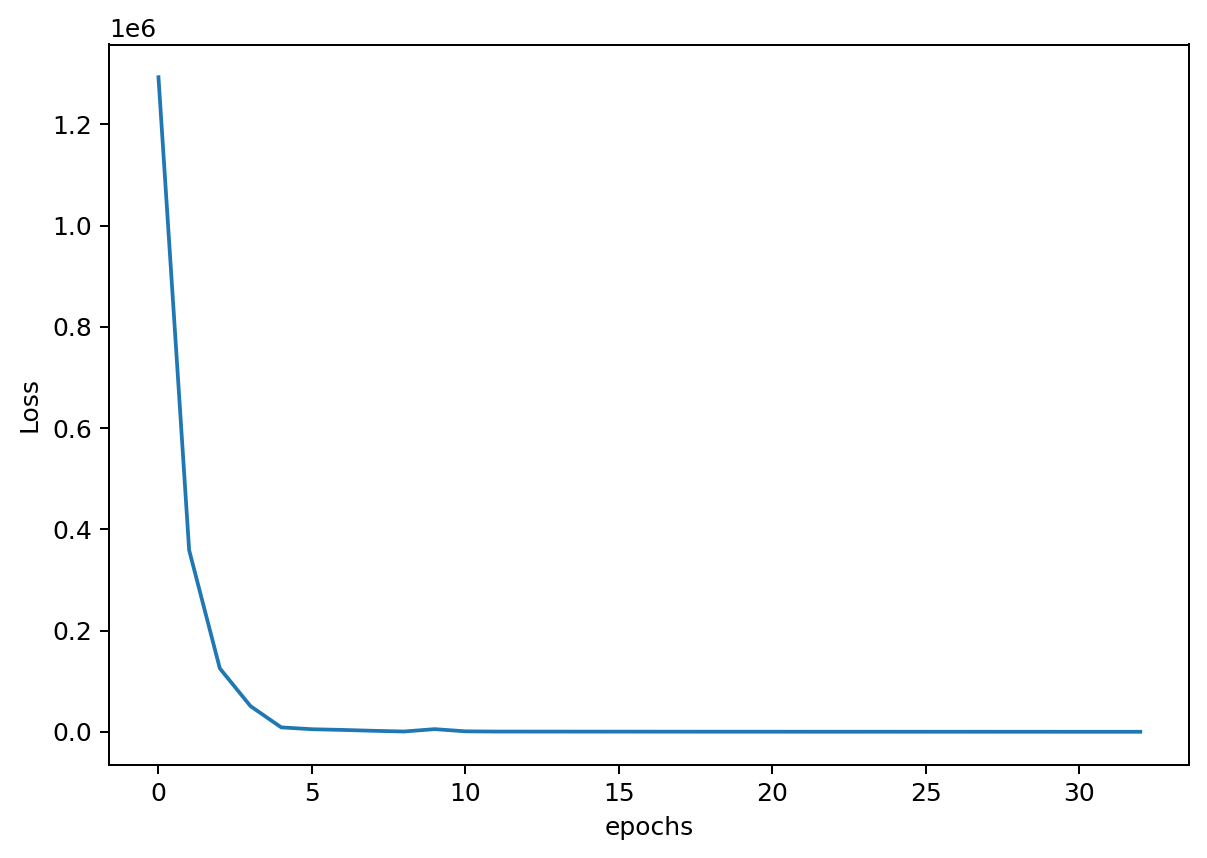

In [25]:
fig = plt.figure(dpi=180)
ax = fig.add_axes([0,0,1,1])
ax.plot(list(range(len(df))),df['losses'])
# ax.legend(labels=['Churn'])
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
plt.show()

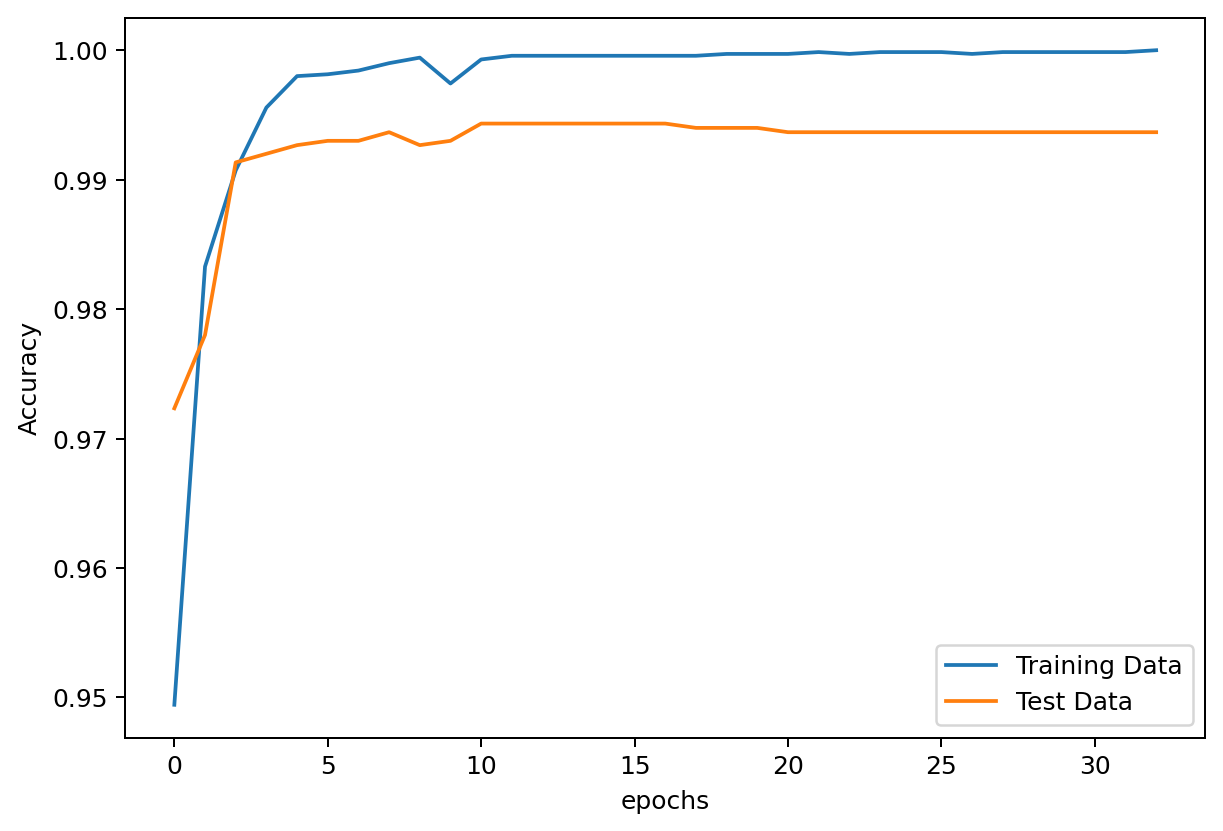

In [26]:
fig = plt.figure(dpi=180)
ax = fig.add_axes([0,0,1,1])
ax.plot(list(range(len(df))),df['train_accs'])
ax.plot(list(range(len(df))),df['test_accs'])
ax.legend(labels=['Training Data', 'Test Data'])
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
plt.show()

### Multi-layer Perceptron

In [27]:
with open(os.path.join('results', '42.json'), 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,losses,train_accs,test_accs
0,0.685363,0.797250,0.8055
1,0.651435,0.883250,0.8860
2,0.612156,0.913500,0.9105
3,0.559950,0.937875,0.9335
4,0.494259,0.956750,0.9470


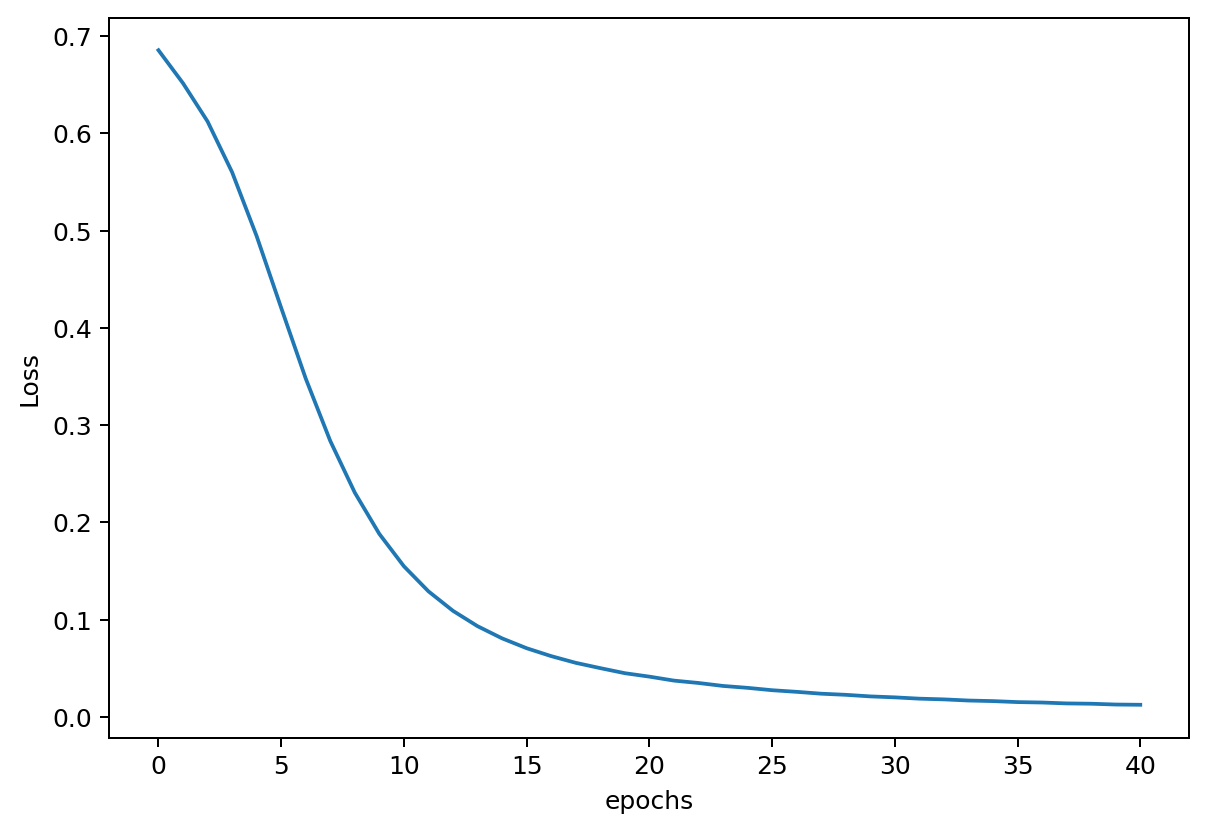

In [28]:
fig = plt.figure(dpi=180)
ax = fig.add_axes([0,0,1,1])
ax.plot(list(range(len(df))),df['losses'])
# ax.legend(labels=['Churn'])
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
plt.show()

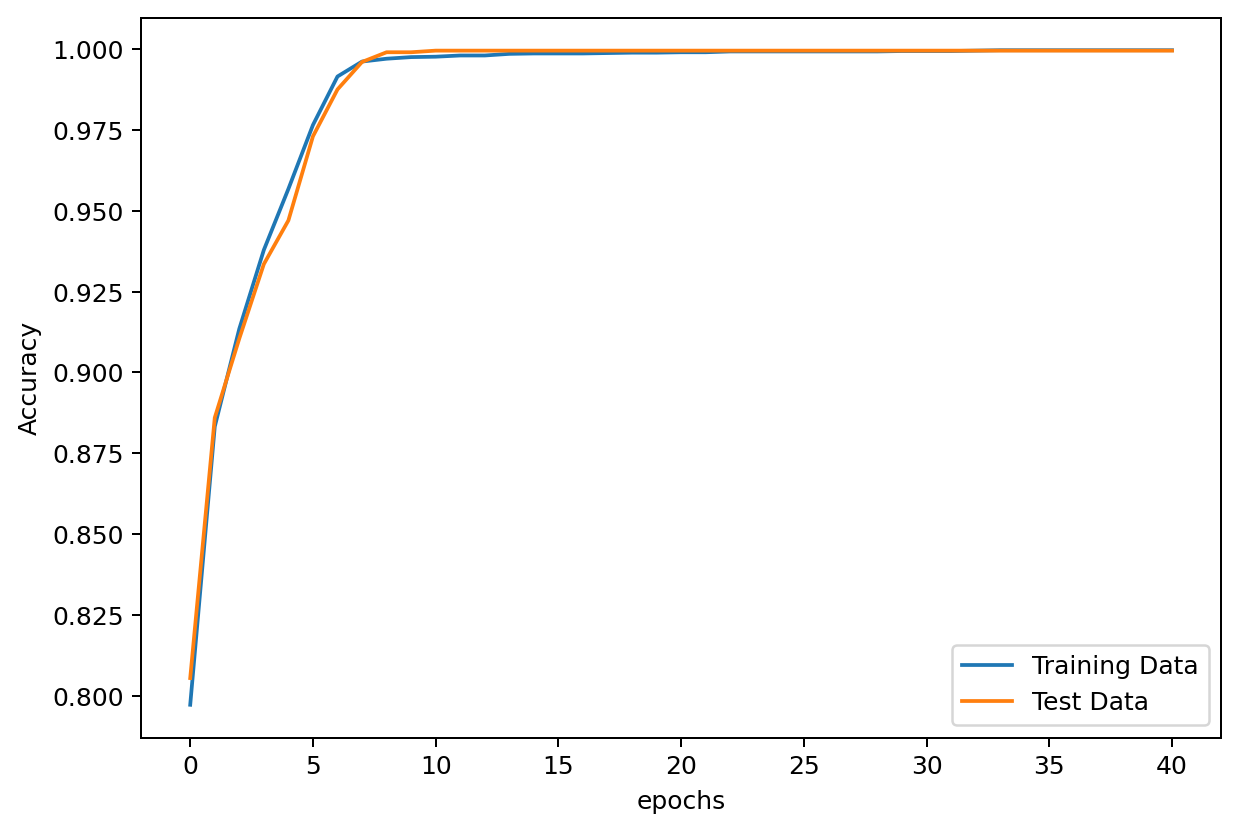

In [29]:
fig = plt.figure(dpi=180)
ax = fig.add_axes([0,0,1,1])
ax.plot(list(range(len(df))),df['train_accs'])
ax.plot(list(range(len(df))),df['test_accs'])
ax.legend(labels=['Training Data', 'Test Data'])
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
plt.show()